# Import Libraries

In [2]:
import os

import pandas as pd
import numpy as np
import missingno as msno
import impyute as impy
import miceforest as mf

from statsmodels.multivariate.pca import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA as sklearnPCA

from MissForest import MissForest

from matplotlib import pyplot as plt
import seaborn as sns

import datawig

# Lab Values

## Load Data

In [3]:
path = os.getcwd() + '/../../data/mimic_omop_selected_vitals.csv'
originalDf = pd.read_csv(path)

In [4]:
originalDf.head()

,Unnamed: 0,visit_occurrence_id,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
0,0,-2147462198,100.764706,112.764706,77.411765,88.823529,19.941176,36.788889,97.470588,4.0,5.0,6.0
1,1,-2147363710,92.400000,106.640000,54.840000,70.120000,13.942857,36.886957,97.600000,2.5,3.0,3.5
2,2,-2147110420,67.761905,109.842105,41.578947,56.736842,17.916667,36.016667,99.950000,2.0,1.0,2.5
3,3,-2147080626,127.925926,116.291667,72.708333,82.375000,29.185185,37.222222,94.115385,4.0,5.0,6.0
4,4,-2147002424,101.370370,103.840000,57.200000,71.480000,22.851852,36.666667,148.333333,4.0,4.4,6.0


In [5]:
originalDf = originalDf.iloc[: , 1:]
originalDf.set_index('visit_occurrence_id', inplace=True)

In [6]:
originalDf.head()

,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
visit_occurrence_id,,,,,,,,,,
-2147462198,100.764706,112.764706,77.411765,88.823529,19.941176,36.788889,97.470588,4.0,5.0,6.0
-2147363710,92.400000,106.640000,54.840000,70.120000,13.942857,36.886957,97.600000,2.5,3.0,3.5
-2147110420,67.761905,109.842105,41.578947,56.736842,17.916667,36.016667,99.950000,2.0,1.0,2.5
-2147080626,127.925926,116.291667,72.708333,82.375000,29.185185,37.222222,94.115385,4.0,5.0,6.0
-2147002424,101.370370,103.840000,57.200000,71.480000,22.851852,36.666667,148.333333,4.0,4.4,6.0


## Visualize Missing Proportion

In [7]:
missingSeries = originalDf.isna().sum().sort_values()

In [8]:
missingSeries

heartrate      70
resprate      100
meanbp        121
spo2          126
sysbp         262
diabp         262
gcseye        335
gcsverbal     359
gcsmotor      376
tempc        1043
dtype: int64

<AxesSubplot:>

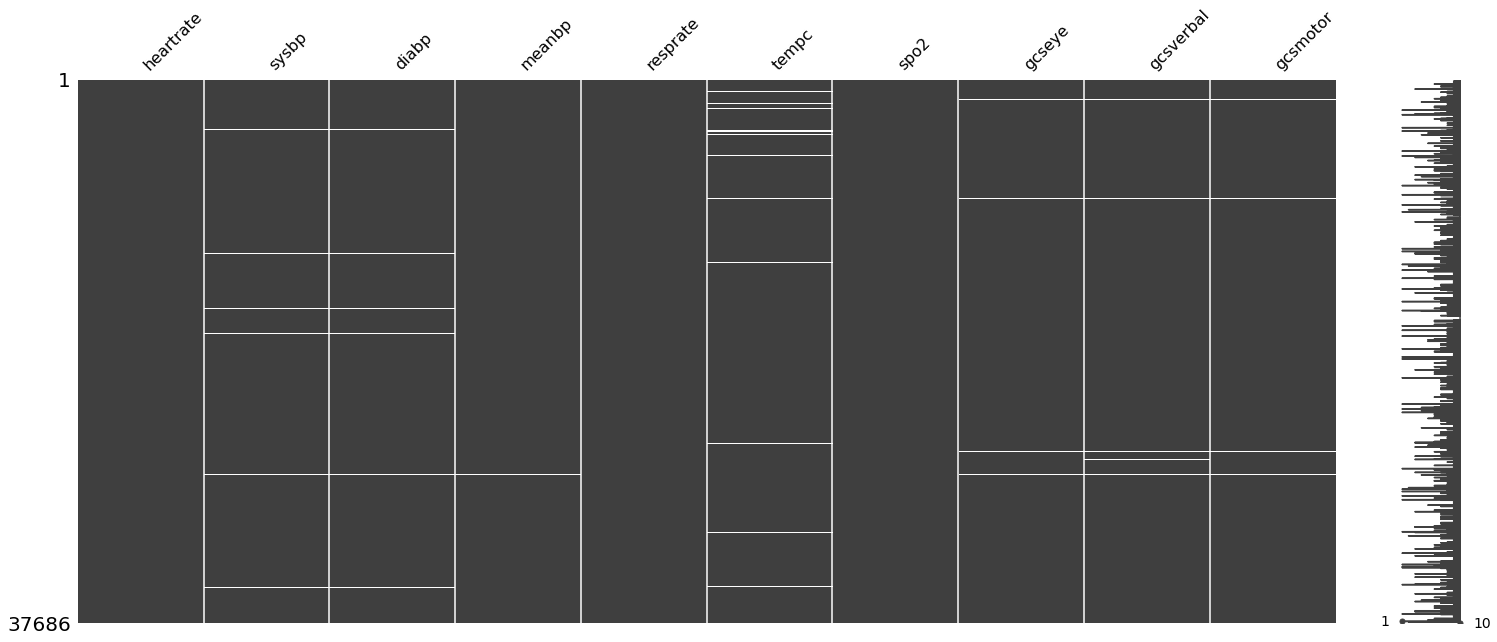

In [9]:
msno.matrix(originalDf)

<AxesSubplot:>

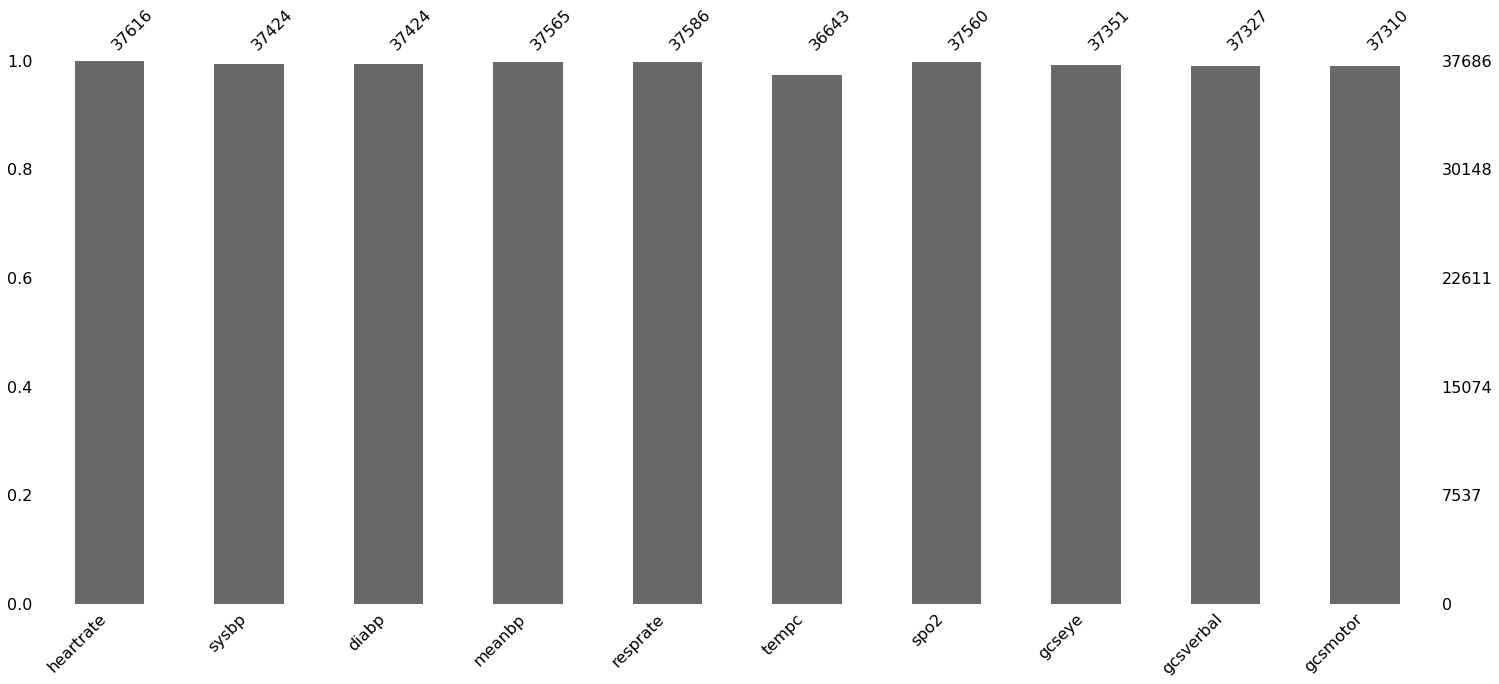

In [10]:
msno.bar(originalDf)

## Drop Rows with Missing Values

In [11]:
dataDf = originalDf.dropna()

In [12]:
dataDf.isna().sum().sort_values()

heartrate    0
sysbp        0
diabp        0
meanbp       0
resprate     0
tempc        0
spo2         0
gcseye       0
gcsverbal    0
gcsmotor     0
dtype: int64

<AxesSubplot:>

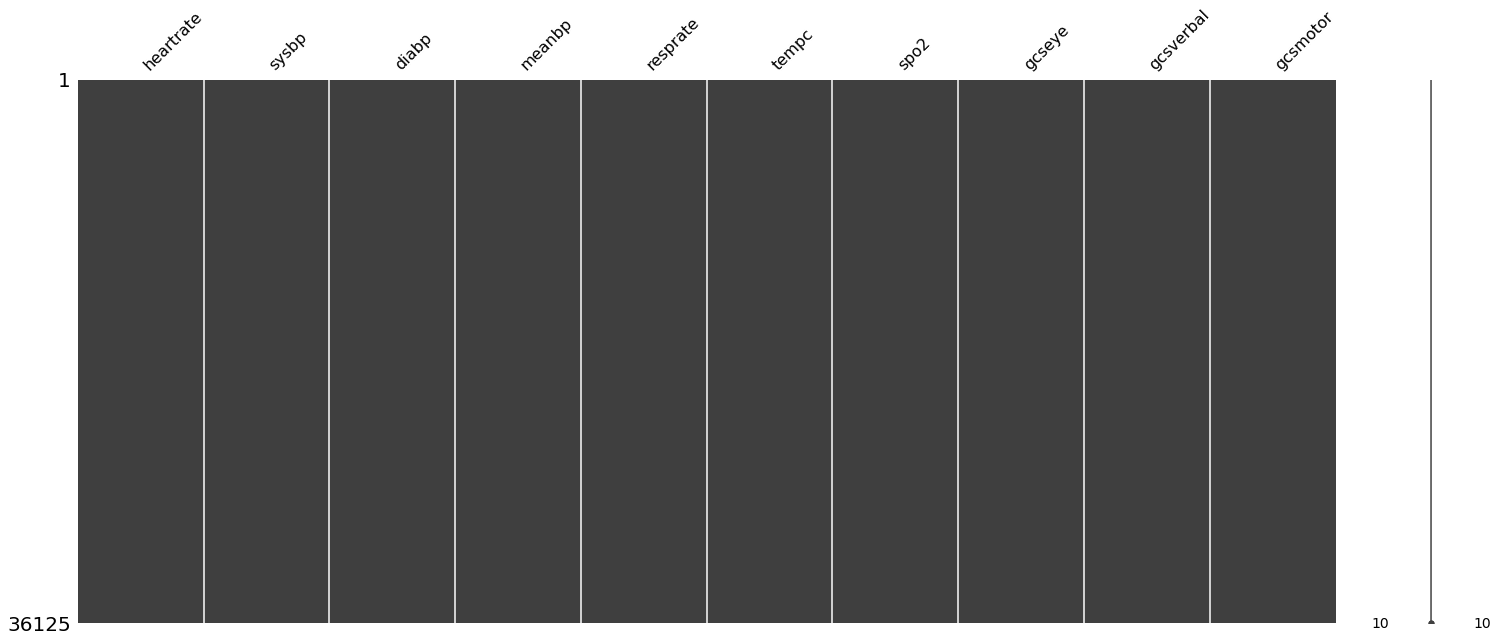

In [13]:
msno.matrix(dataDf)

## Imputation for different proportions of missing data

In [16]:
plotData = []
for p in [*range(1, 50, 3)]:

    print('p: ', p)

    proportions = (p/100), round((1-(p/100)), 2)
    mask = np.random.choice(a=[True, False], size=dataDf.shape, p=proportions)
    missingDf = dataDf.mask(mask)

    meanImputer = SimpleImputer(strategy='mean')
    meanImputedData = meanImputer.fit_transform(missingDf)
    meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in missingDf.columns], index=missingDf.index)
    meanMse = mean_squared_error(dataDf, meanImputedDf)
    meanR2 = r2_score(dataDf, meanImputedDf)

    medianImputer = SimpleImputer(strategy='median')
    medianImputedData = medianImputer.fit_transform(missingDf)
    medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in missingDf.columns], index=missingDf.index)
    medianMse = mean_squared_error(dataDf, medianImputedDf)
    medianR2 = r2_score(dataDf, medianImputedDf)

    knnImputer = KNNImputer()
    knnImputedData = knnImputer.fit_transform(missingDf)
    knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in missingDf.columns], index=missingDf.index)
    knnMse = mean_squared_error(dataDf, knnImputedDf)
    knnR2 = r2_score(dataDf, knnImputedDf)

    mfImputer = MissForest()
    mfImputedData = mfImputer.fit_transform(missingDf)
    mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)
    mfMse = mean_squared_error(dataDf, mfImputedDf)
    mfR2 = r2_score(dataDf, mfImputedDf)

    try:
        pc = PCA(data=missingDf, ncomp=1, missing='fill-em', method='nipals')
        nipalsImputedDf = pd.DataFrame(pc._adjusted_data)
        nipalsMse = mean_squared_error(dataDf, nipalsImputedDf)
        nipalsR2 = r2_score(dataDf, nipalsImputedDf)
    except:
        pass

    emImputedData = impy.em(missingDf.to_numpy())
    emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in missingDf.columns], index=missingDf.index)
    emMse = mean_squared_error(dataDf, emImputedDataDf)
    emR2 = r2_score(dataDf, emImputedDataDf)

    # Create kernel. 
    miKernel = mf.ImputationKernel(
      missingDf,
      datasets=4,
      save_all_iterations=True,
      random_state=1
    )
    # Run the MICE algorithm for 2 iterations on each of the datasets
    miKernel.mice(2)
    miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
    miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in missingDf.columns], index=missingDf.index)
    miMse = mean_squared_error(dataDf, miImputedDf)
    miR2 = r2_score(dataDf, miImputedDf)

    plotData.append([p, meanMse, medianMse, knnMse, mfMse, nipalsMse, emMse, miMse, meanR2, medianR2, knnR2, mfR2, nipalsR2, emR2, miR2])

plotDf = pd.DataFrame(plotData, columns=['missing_proportion', 'mean_mse', 'median_mse', 'knn_mse', 'mf_mse', 'nipals_mse', 'em_mse', 'mi_mse', 'mean_r2', 'median_r2', 'knn_r2', 'mf_r2', 'nipals_r2', 'em_r2', 'mi_r2'])

p:  1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  7
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  10
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  13
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  16
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  22
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  25
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  28
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  31
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  34
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  37
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  40
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  43
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  46
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  49
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [17]:
plotDf.to_csv('temp_plot_df.csv')

In [18]:
plotDf

,missing_proportion,mean_mse,median_mse,knn_mse,mf_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,em_r2,mi_r2
0,1,0.930491,0.934704,0.452241,1.132301,0.922256,153.621532,0.681113,0.995998,0.994687,0.997437,0.998585,0.997863,0.987454,0.996911
1,4,3.471427,3.488002,18.898202,15.219791,3.499545,624.856945,4.018969,0.983666,0.978630,0.988833,0.992320,0.991493,0.948539,0.987912
2,7,7.326304,7.353821,312.364742,2493.204082,7.332659,1161.252585,56.690300,0.971417,0.963205,0.974775,0.951778,0.984951,0.909184,0.972119
3,10,499.366805,499.696324,533.744554,1799.792876,499.395908,2227.615692,612.201201,0.846532,0.834640,0.856447,0.852543,0.865135,0.765354,0.840715
4,13,1889.671357,1890.141512,1896.005684,1975.066443,1889.614703,4037.936537,2078.006368,0.821347,0.806479,0.839378,0.846974,0.843071,0.712604,0.833296
5,16,16527.937809,16529.140238,16601.194239,16549.264536,16528.166388,17124.688364,16566.698288,0.720149,0.700785,0.736919,0.755805,0.747507,0.598249,0.730859
6,19,9800.245056,9801.454624,9860.299768,9820.559567,9800.932116,11652.938532,9876.832799,0.780864,0.758559,0.796860,0.820121,0.803668,0.619880,0.786951
7,22,147.505136,147.621647,160.050937,1836.414776,983.768645,4530.613666,195.449501,0.903417,0.876416,0.927165,0.922766,0.395484,0.683880,0.912940
8,25,7854.117599,7854.720257,7901.870734,8017.500594,7858.401243,10918.202941,7970.110354,0.705047,0.674866,0.732719,0.746018,0.716681,0.498643,0.704345
9,28,565.447988,565.958750,582.177361,4587.532752,583.297505,6534.859547,700.326280,0.858515,0.824906,0.887056,0.829031,0.875834,0.569676,0.872176


In [19]:
plotDf = pd.read_csv('temp_plot_df.csv')

In [20]:
plotDf

,Unnamed: 0,missing_proportion,mean_mse,median_mse,knn_mse,mf_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,em_r2,mi_r2
0,0,1,0.930491,0.934704,0.452241,1.132301,0.922256,153.621532,0.681113,0.995998,0.994687,0.997437,0.998585,0.997863,0.987454,0.996911
1,1,4,3.471427,3.488002,18.898202,15.219791,3.499545,624.856945,4.018969,0.983666,0.978630,0.988833,0.992320,0.991493,0.948539,0.987912
2,2,7,7.326304,7.353821,312.364742,2493.204082,7.332659,1161.252585,56.690300,0.971417,0.963205,0.974775,0.951778,0.984951,0.909184,0.972119
3,3,10,499.366805,499.696324,533.744554,1799.792876,499.395908,2227.615692,612.201201,0.846532,0.834640,0.856447,0.852543,0.865135,0.765354,0.840715
4,4,13,1889.671357,1890.141512,1896.005684,1975.066443,1889.614703,4037.936537,2078.006368,0.821347,0.806479,0.839378,0.846974,0.843071,0.712604,0.833296
5,5,16,16527.937809,16529.140238,16601.194239,16549.264536,16528.166388,17124.688364,16566.698288,0.720149,0.700785,0.736919,0.755805,0.747507,0.598249,0.730859
6,6,19,9800.245056,9801.454624,9860.299768,9820.559567,9800.932116,11652.938532,9876.832799,0.780864,0.758559,0.796860,0.820121,0.803668,0.619880,0.786951
7,7,22,147.505136,147.621647,160.050937,1836.414776,983.768645,4530.613666,195.449501,0.903417,0.876416,0.927165,0.922766,0.395484,0.683880,0.912940
8,8,25,7854.117599,7854.720257,7901.870734,8017.500594,7858.401243,10918.202941,7970.110354,0.705047,0.674866,0.732719,0.746018,0.716681,0.498643,0.704345
9,9,28,565.447988,565.958750,582.177361,4587.532752,583.297505,6534.859547,700.326280,0.858515,0.824906,0.887056,0.829031,0.875834,0.569676,0.872176


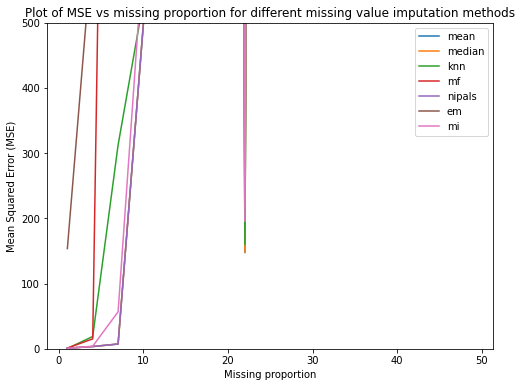

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf.missing_proportion, plotDf.mean_mse, label='mean')
plt.plot(plotDf.missing_proportion, plotDf.median_mse, label='median')
plt.plot(plotDf.missing_proportion, plotDf.knn_mse, label='knn')
plt.plot(plotDf.missing_proportion, plotDf.mf_mse, label='mf')
plt.plot(plotDf.missing_proportion, plotDf.nipals_mse, label='nipals')
plt.plot(plotDf.missing_proportion, plotDf.em_mse, label='em')
plt.plot(plotDf.missing_proportion, plotDf.mi_mse, label='mi')
plt.ylim([0, 500])
plt.title('Plot of MSE vs missing proportion for different missing value imputation methods')
plt.xlabel('Missing proportion')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

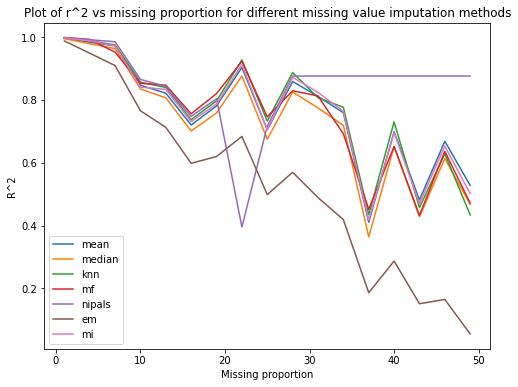

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf.missing_proportion, plotDf.mean_r2, label='mean')
plt.plot(plotDf.missing_proportion, plotDf.median_r2, label='median')
plt.plot(plotDf.missing_proportion, plotDf.knn_r2, label='knn')
plt.plot(plotDf.missing_proportion, plotDf.mf_r2, label='mf')
plt.plot(plotDf.missing_proportion, plotDf.nipals_r2, label='nipals')
plt.plot(plotDf.missing_proportion, plotDf.em_r2, label='em')
plt.plot(plotDf.missing_proportion, plotDf.mi_r2, label='mi')
plt.title('Plot of r^2 vs missing proportion for different missing value imputation methods')
plt.xlabel('Missing proportion')
plt.ylabel('R^2')
plt.legend()
plt.show()

## Imputation for different number of variables in missing data

In [23]:
plotData1 = []
cols = []
for index, value in missingSeries.items():
    print(f"Index : {index}, Value : {value}")
    cols.append(index)
    
    if len(cols) <3:
        continue

    subDf = dataDf[cols]
    mask = np.random.choice(a=[True, False], size=subDf.shape, p=[0.1, 0.9])
    submaskedDf = subDf.mask(mask)

    meanImputer = SimpleImputer(strategy='mean')
    meanImputedData = meanImputer.fit_transform(submaskedDf)
    meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in submaskedDf.columns], index=submaskedDf.index)
    meanMse = mean_squared_error(subDf, meanImputedDf)
    meanR2 = r2_score(subDf, meanImputedDf)

    medianImputer = SimpleImputer(strategy='median')
    medianImputedData = medianImputer.fit_transform(submaskedDf)
    medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in submaskedDf.columns], index=submaskedDf.index)
    medianMse = mean_squared_error(subDf, medianImputedDf)
    medianR2 = r2_score(subDf, medianImputedDf)

    knnImputer = KNNImputer()
    knnImputedData = knnImputer.fit_transform(submaskedDf)
    knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in submaskedDf.columns], index=submaskedDf.index)
    knnMse = mean_squared_error(subDf, knnImputedDf)
    knnR2 = r2_score(subDf, knnImputedDf)

    mfImputer = MissForest()
    mfImputedData = mfImputer.fit_transform(submaskedDf)
    mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in submaskedDf.columns], index=submaskedDf.index)
    mfMse = mean_squared_error(subDf, mfImputedDf)
    mfR2 = r2_score(subDf, mfImputedDf)

    try:
        pc = PCA(data=submaskedDf, ncomp=1, missing='fill-em', method='nipals')
        nipalsMmputedDf = pd.DataFrame(pc._adjusted_data)
        nipalsMse = mean_squared_error(subDf, nipalsMmputedDf)
        nipalsR2 = r2_score(subDf, nipalsImputedDf)
    except:
        pass

    emImputedData = impy.em(submaskedDf.to_numpy())
    emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in submaskedDf.columns], index=submaskedDf.index)
    emMse = mean_squared_error(subDf, emImputedDataDf)
    emR2 = r2_score(subDf, emImputedDataDf)

    # Create kernel. 
    miKernel = mf.ImputationKernel(
      submaskedDf,
      datasets=4,
      save_all_iterations=True,
      random_state=1
    )
    # Run the MICE algorithm for 2 iterations on each of the datasets
    miKernel.mice(2)
    miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
    miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in submaskedDf.columns], index=submaskedDf.index)
    miMse = mean_squared_error(subDf, miImputedDf)
    miR2 = r2_score(subDf, miImputedDf)

    plotData1.append([str(len(cols)), meanMse, medianMse, knnMse, mfMse, nipalsMse, emMse, miMse, meanR2, medianR2, knnR2, mfR2, nipalsR2, emR2, miR2])

plotDf1 = pd.DataFrame(plotData1, columns=['no_of_cols', 'mean_mse', 'median_mse', 'knn_mse', 'mf_mse', 'nipals_mse', 'em_mse', 'mi_mse', 'mean_r2', 'median_r2', 'knn_r2', 'mf_r2', 'nipals_r2', 'em_r2', 'mi_r2'])

Index : heartrate, Value : 70
Index : resprate, Value : 100
Index : meanbp, Value : 121
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : spo2, Value : 126
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : sysbp, Value : 262
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : diabp, Value : 262
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : gcseye, Value : 335
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : gcsverbal, Value : 359
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : gcsmotor, Value : 376
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : tempc, Value : 1043
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: 15 columns passed, passed data had 17 columns

In [27]:
plotDf1.to_csv('temp_plot_df_1.csv')

In [28]:
plotDf1

,no_of_cols,mean_mse,median_mse,knn_mse,mf_mse,dw_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,dw_r2,em_r2,mi_r2
0,3,14.843361,14.651589,69.635516,884.332098,583.297505,10035.43867,5030.291106,655.529411,0.969853,0.969664,0.963474,0.959567,0.875834,-1.072553,0.881211,0.941313
1,4,11.912736,11.764472,28.031418,639.910799,583.297505,10035.43867,4073.222461,20.582860,0.976516,0.976341,0.973009,0.956263,0.875834,-1.072553,0.887601,0.958259
2,5,884.683297,885.003605,887.727723,894.580367,1703.275704,10035.43867,4336.572392,889.213515,0.838056,0.837927,0.834979,0.838264,0.875834,-1.072553,0.759945,0.824965
3,6,2900.741472,2901.053898,2901.814719,2950.863005,3025.711492,10035.43867,5604.388235,2898.689786,0.778767,0.778569,0.775066,0.779423,0.875834,-1.072553,0.704545,0.768477
4,7,2386.338293,2386.470108,2401.241873,2402.427827,2470.226258,10035.43867,4706.037442,2385.884809,0.811919,0.807306,0.808230,0.814311,0.875834,-1.072553,0.734330,0.795229
5,8,327.719686,328.131300,2720.638576,353.098076,408.852430,10035.43867,2578.134667,327.086061,0.941288,0.929402,0.915081,0.955608,0.875834,-1.072553,0.851136,0.941569
6,9,43.355447,43.386568,400.412797,1736.698528,43.435558,10035.43867,1987.880787,45.870608,0.948804,0.934864,0.923576,0.957659,0.875834,-1.072553,0.856750,0.960697
7,10,7300.379029,7300.616122,7306.074231,7444.121361,7306.628347,10035.43867,8485.015076,7302.686456,0.854897,0.843543,0.868061,0.870976,-3116.775611,-1.072553,0.770364,0.866744


In [29]:
plotDf1 = pd.read_csv('temp_plot_df_1.csv')

In [30]:
plotDf1

,Unnamed: 0,no_of_cols,mean_mse,median_mse,knn_mse,mf_mse,dw_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,dw_r2,em_r2,mi_r2
0,0,3,14.843361,14.651589,69.635516,884.332098,583.297505,10035.43867,5030.291106,655.529411,0.969853,0.969664,0.963474,0.959567,0.875834,-1.072553,0.881211,0.941313
1,1,4,11.912736,11.764472,28.031418,639.910799,583.297505,10035.43867,4073.222461,20.582860,0.976516,0.976341,0.973009,0.956263,0.875834,-1.072553,0.887601,0.958259
2,2,5,884.683297,885.003605,887.727723,894.580367,1703.275704,10035.43867,4336.572392,889.213515,0.838056,0.837927,0.834979,0.838264,0.875834,-1.072553,0.759945,0.824965
3,3,6,2900.741472,2901.053898,2901.814719,2950.863005,3025.711492,10035.43867,5604.388235,2898.689786,0.778767,0.778569,0.775066,0.779423,0.875834,-1.072553,0.704545,0.768477
4,4,7,2386.338293,2386.470108,2401.241873,2402.427827,2470.226258,10035.43867,4706.037442,2385.884809,0.811919,0.807306,0.808230,0.814311,0.875834,-1.072553,0.734330,0.795229
5,5,8,327.719686,328.131300,2720.638576,353.098076,408.852430,10035.43867,2578.134667,327.086061,0.941288,0.929402,0.915081,0.955608,0.875834,-1.072553,0.851136,0.941569
6,6,9,43.355447,43.386568,400.412797,1736.698528,43.435558,10035.43867,1987.880787,45.870608,0.948804,0.934864,0.923576,0.957659,0.875834,-1.072553,0.856750,0.960697
7,7,10,7300.379029,7300.616122,7306.074231,7444.121361,7306.628347,10035.43867,8485.015076,7302.686456,0.854897,0.843543,0.868061,0.870976,-3116.775611,-1.072553,0.770364,0.866744


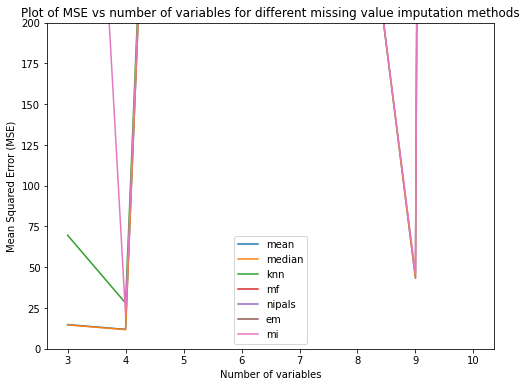

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf1.no_of_cols, plotDf1.mean_mse, label='mean')
plt.plot(plotDf1.no_of_cols, plotDf1.median_mse, label='median')
plt.plot(plotDf1.no_of_cols, plotDf1.knn_mse, label='knn')
plt.plot(plotDf1.no_of_cols, plotDf1.mf_mse, label='mf')
plt.plot(plotDf1.no_of_cols, plotDf1.nipals_mse, label='nipals')
plt.plot(plotDf1.no_of_cols, plotDf1.em_mse, label='em')
plt.plot(plotDf1.no_of_cols, plotDf1.mi_mse, label='mi')
plt.ylim([0, 200])
plt.title('Plot of MSE vs number of variables for different missing value imputation methods')
plt.xlabel('Number of variables')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

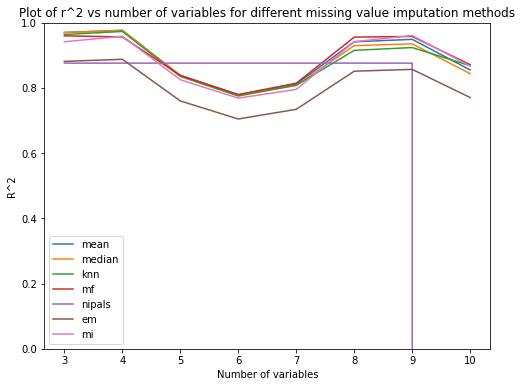

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf1.no_of_cols, plotDf1.mean_r2, label='mean')
plt.plot(plotDf1.no_of_cols, plotDf1.median_r2, label='median')
plt.plot(plotDf1.no_of_cols, plotDf1.knn_r2, label='knn')
plt.plot(plotDf1.no_of_cols, plotDf1.mf_r2, label='mf')
plt.plot(plotDf1.no_of_cols, plotDf1.nipals_r2, label='nipals')
plt.plot(plotDf1.no_of_cols, plotDf1.em_r2, label='em')
plt.plot(plotDf1.no_of_cols, plotDf1.mi_r2, label='mi')
plt.ylim([0, 1])
plt.title('Plot of r^2 vs number of variables for different missing value imputation methods')
plt.xlabel('Number of variables')
plt.ylabel('R^2')
plt.legend()
plt.show()

## MissForest imputation evaluation

In [24]:
data = []
for p in range(2, 30, 5):

    print('p: ', p)

    proportions = (p/100), round((1-(p/100)), 2)
    mask = np.random.choice(a=[True, False], size=dataDf.shape, p=proportions)
    missingDf = dataDf.mask(mask)

    mfImputer = MissForest()
    imputedData = mfImputer.fit_transform(missingDf)
    imputedDf = pd.DataFrame(imputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)

    data.append([p, missingDf, imputedDf])

p:  2
Iteration: 0
Iteration: 1
Iteration: 2
p:  7
Iteration: 0
Iteration: 1
Iteration: 2
p:  12
Iteration: 0
Iteration: 1
Iteration: 2
p:  17
Iteration: 0
Iteration: 1
p:  22
Iteration: 0
Iteration: 1
Iteration: 2
p:  27
Iteration: 0
Iteration: 1


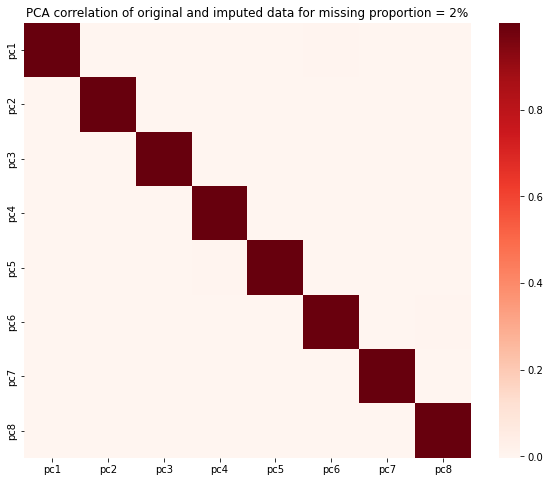

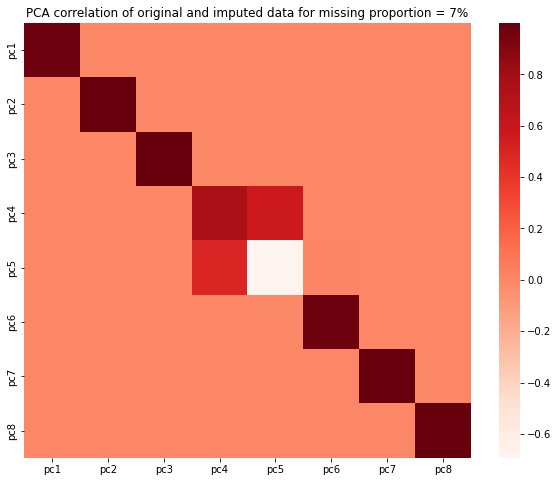

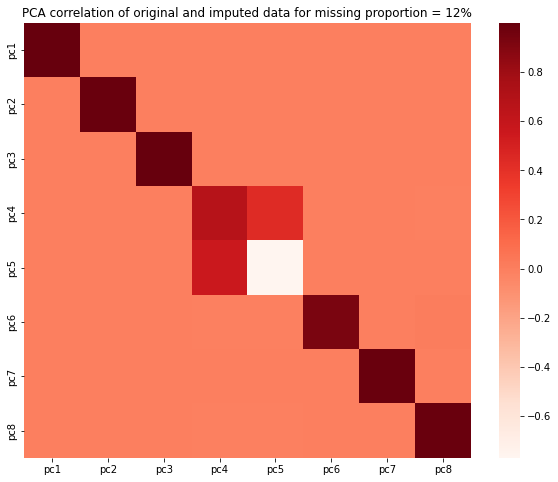

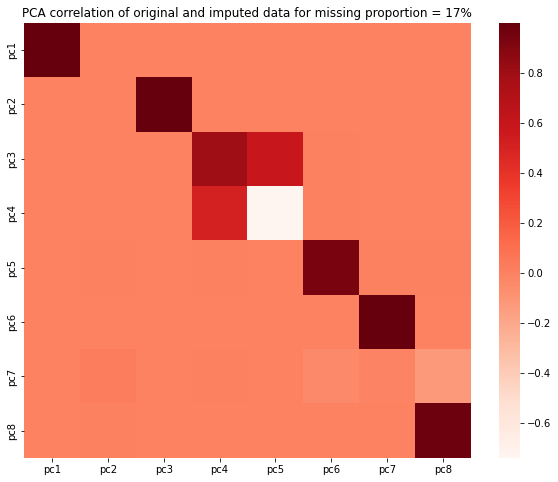

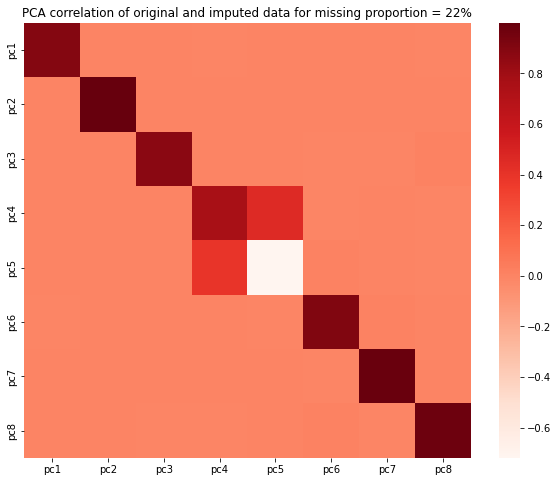

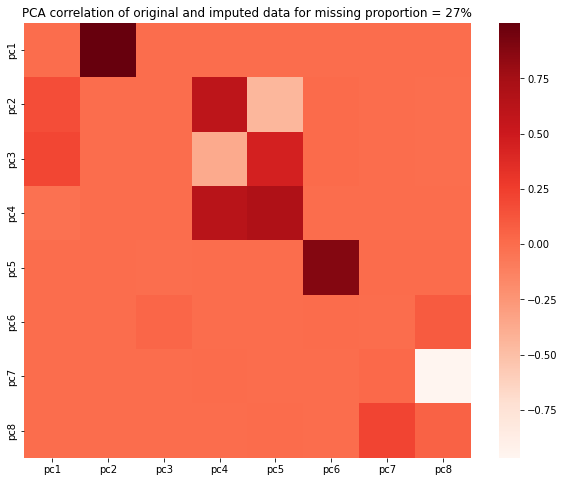

In [25]:
for i in range(len(data)):
    pca1 = sklearnPCA(n_components=8)
    dataPc = pca1.fit_transform(dataDf)
    dataPcDf = pd.DataFrame(data = dataPc, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'])

    pca2 = sklearnPCA(n_components=8)
    missingPc = pca2.fit_transform(data[i][2])
    missingPcDf = pd.DataFrame(data = missingPc, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.concat([dataPcDf, missingPcDf], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'], cmap="Reds")
    plt.title('PCA correlation of original and imputed data for missing proportion = ' + str(data[i][0]) + '%')
    plt.show()